# UQ ON INVERSE PROBLEMS ON MEMBRANE # 

In this notebook, we will look at the inverse problem on the contact area of the membrane. This can be formulated as:

$$
T\nabla^2 h = p_0 - f, \qquad x \in \Omega 
$$

with the following assumption of (1) *uniform* and *isotropic* tension and (2) *no friction* acting on the membrane. 

## FORWARD PROBLEM ##

Assume homogeneous Dirichlet boundary conditions on $h$, (i.e. $h|_{\partial \Omega} = 0$.) 
Then we write equation the previous equation in weak form as: 
$$
(\nabla w, T \nabla h) = (w,f-po) \qquad \forall w \in V 
$$

$$
V = \left\{ w(x_1,x_2) \in H^1(\Omega); w|_{\partial \Omega} = 0 \right\}
$$

For any given $f$, we can easily achieved a solution $h$. This defines $\mathbf{H_0}$:
$$
\mathbf{h} = \mathbf{H_0}[\mathbf{f}]
$$

In discrete form, we can write $\mathbf{K}\mathbf{h_h} = \mathbf{f_h} - p_0\mathbf{I}$.  Therefore, in the inverse direction:
$$
\mathbf{h_h} = \mathbf{H_0}[\mathbf{f}] = \mathbf{K}^{-1}(\mathbf{f_h} - p_0\mathbf{I})
$$

## PRIOR ASSUMPTIONS ON F ## 

There are certain assumptions that is needed to determine the membrane of the problem. 

- Assume breast tissue has a shear modulus of roughly $10 kPa$.  
- Assume that desired strain increments are about $1\%$.  
- In uniaxial compression, this gives an average $f \approx 10 kPa \times 0.01 = 0.1 kPa$.
- Therefore, we shall assume that the mean $ \bar{f} = 0.1 kPa$. Yet it should also be expected that the applied traction could potentially be $30$ times larger or smaller than the quoted value.
- Therefore, we shall assume that $log\dfrac{f}{f_0} \sim \exp \left \{ -\frac{1}{2\sigma^2} \|log\dfrac{f}{f_0} \|^2 \right\} $, with $\sigma = 100$.
- Furthermore, we expect the correlation length of the $f$ to scale with breast shape.  That is, we should expect the correlation length to be $l = O(1 cm-10 cm)$.  
- Taking $l = 1 cm = 10 mm$, this gives $log\dfrac{f}{f_0} \sim \exp \left \{ -\frac{1}{2\sigma^2} \left[ l^{2} \| \nabla log\dfrac{f}{f_0} \|^2 + \|log\dfrac{f}{f_0} \|^2 \right] \right\} $.

In this report, a *linear model* for $f$ is used instead of the *log model* proposed above. Now let:

$$
\begin{aligned}
f &= f_{0}(1 + \psi) \\ 
\psi &= \frac{f - f_{0}}{f_{0}}
\end{aligned}
$$

Using Taylor expansion leads us to:

$$
log \Big( \frac{f}{f_{0}} \Big ) = log(1 + \psi) = \psi + O(\psi ^{2})
$$

Hence, this means the two log terms included in the priior assumptions can be approximated as:

\begin{equation*}
log \Big( \frac{f}{f_{0}} \Big ) \approx \psi
\end{equation*}

which gives us an alternative prior PDF for $f$ as:
$$
log\dfrac{f}{f_0} \sim \exp \left \{-\frac{1}{2\sigma^2} \left[ l^{2} \| \nabla \psi \|^2 + \|\psi \|^2 \right] \right\}
$$

Replacing $\psi$ to obtain:

$$
log\dfrac{f}{f_0} \sim \exp \left \{-\frac{1}{2\sigma^2 f_0^2} \left[ l^{2} \| \nabla f \|^2 + \| f - f_0 \|^2 \right] \right\}
$$

# POSTERIOR PDF AND MAP OF F #

Now in Bayes framework, it is stated that:

$$
\mathbf{\pi}_{posterior} \sim \mathbf{\pi}_{data} \times \mathbf{\pi}_{prior}
$$

Following this, it is deduced that the posterior PDF of f is:

$$
D \sim   \left \{ \frac{1}{2\sigma_{data}^2}\| \tilde{h} - 
\mathbf{K}^{-1}(\mathbf{f_h} - p_0\mathbf{I})\|^2  
+\frac{1}{2\sigma_{prior}^2 f_0^{2}} \left[ l^{2} \| \nabla \mathbf{f_h} \|^2 + \|\mathbf{f_h} - \mathbf{f_{prior}} \|^2 \right] \right\} .
$$
where $\bar{f}$ is the mean value of the prior. 

This has now become an optimisation problem. As previously stated, the mean is given by maximizing the posterior density, and the posterior covariance matrix $\Gamma_{post}$ is given by the inverse of the Hessian matrix of this least squares function.

## SMALL SCALE PROBLEM ## 

### GENERATE FORWARD SOLUTION ### 

Let's ignore the fact that it is implausible to implement $\mathbf{K^{-1}}$ for large-scale problems. Let's check on the behaviour of a small problem. The discretised form of the weak form formulation can be presented as:

$$
T\sum_{\Omega} w_{i}\dfrac{\partial N_{i}}{\partial x_{i}} \dfrac{\partial N_{j}}{\partial x_{j}}h_{j}  = \sum_{\Omega} w_{i}N_{i}(f_{i} - p_0)
$$

in which the $N_{i}$ are the linear shape functions that has the value of 1 at $x_{i}$ and has the value of 0 elsewhere. 

Now define a global stiffness matrix of:

$$
\mathbf{K} = T\dfrac{\partial N_{i}}{\partial x_{i}} \dfrac{\partial N_{j}}{\partial x_{j}}
$$

For 1 element, the elemental stiffness matrix follows:

$$
\mathbf{k_e} = \frac{T}{l_e} 
        \begin{bmatrix}
          1 & -1 \\
          -1 & 1 \\
        \end{bmatrix}
$$

and the RHS vector $\mathbf{b}$ is found by $\mathbf{b} = \int \mathbf{N}^T \mathbf{f}$ where $\mathbf{f}$ is the force vector and $\mathbf{N}$ is the vector including the shape functions at each node.

We arrive at the matrix formulation:

$$
\mathbf{K}\mathbf{h_h} = \mathbf{b_h}
$$

First, let's generate a function that will create the global stiffness matrix and the right hand side vector:

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from scipy.sparse.linalg import cg

In [2]:
# This code is adapted from Garth N. Wells notebook
# which can be found here: http://goo.gl/VZ8W46

def mesh_gen(L, n_cells):
    # Crarte mesh and compute cell size
    n_nodes = n_cells + 1
    mesh = np.linspace(0.0, L, n_nodes)
    return mesh
    
def stiffness_matrix_gen(L, n_cells):
    n_nodes = n_cells + 1
    # Compute locall stiffness matrix
    k_e = -(T/h)*np.array([[1, -1], [-1, 1]])
    
    # Assemble global stiffnes matrix
    K = np.zeros((n_nodes, n_nodes))
    for element in range(n_cells):
        K[element:element + 2, element:element + 2] += k_e
            
    return K

def mass_matrix_gen(L, n_cells):
    n_nodes = n_cells + 1
    h = L/n_cells
    # Compute locall mass matrix
    m_e = -(T/h)*np.array([[1.0/3.0, 1.0/6.0], [1.0/6.0, 1.0/3.0]])
    
    # Assemble global mass matrix
    M = np.zeros((n_nodes, n_nodes))
    for element in range(n_cells):
        M[element:element + 2, element:element + 2] += m_e
            
    return M

def rhs_vector_gen(f, n_cells):
    n_nodes = n_cells + 1
    # Two-point Gauss quadrature points on the interval (-1, 1)
    x_quadrature = ((-1.0/np.sqrt(3.0), 1.0), (1.0/np.sqrt(3.0), 1.0))    

    # Assemble RHS using two-point Gauss quadrature
    b = np.zeros(n_nodes)    
    for element in range(n_cells):

        # Get cell midpoint
        x_mid = (mesh[element + 1] + mesh[element])/2.0    

        # Loop over quadrature points
        for zeta, weight in x_quadrature:        
            # Compute coordinate of point 
            x = x_mid + zeta*h/2.0

            # Evaluate loading term
            f_load = f(x) - p0

            # Quadrature weighta
            w = weight*(h/2.0)
            
            # Compute RHS contributions
            N = 0.5 - zeta/2.0 
            b[element] += w*N*f_load 

            N = 0.5 + zeta/2.0 
            b[element + 1] += w*N*f_load

    return b

#### Case 1: $f = 1.0$ ####

Now let's look at a simple function of $f$. Combine this with the boundary condition $h(0) = h(L) = 0$, we arrive at:

$$
h = \dfrac{f - p_0}{2T}x(x-L)
$$

In [3]:
# Parameter for the problem
T = 10.0
p0 = 5.0

# Length and number of nodes
L = 10.0
n_cells = 50
h = L / n_cells # mesh size

In [4]:
def f_1(x):
    return np.ones(x.size) 

In [5]:
def h_1(x):
    return ((1.0-p0)/(2*T))*x*(x - L)

In [6]:
K_1 = stiffness_matrix_gen(L, n_cells)

# Apply boundary condition
K_1[0, :], K_1[:, 0], K_1[0, 0] = 0.0, 0.0, 1.0
K_1[n_cells, :], K_1[:, n_cells], K_1[n_cells, n_cells] = 0.0, 0.0, 1.0

mesh = mesh_gen(L, n_cells)
b_1 = rhs_vector_gen(f_1, n_cells)

# Apply boundary condition
b_1[0] = 0.0
b_1[n_cells] = 0.0

Now, let's compute the FEM solution $y_{fe}$ using 

$$
\mathbf{h}_{fe} = \mathbf{K^{-1}}\mathbf{b_h}
$$

Let's compare that with the analytical solution by plotting these two graphs on the same plot:

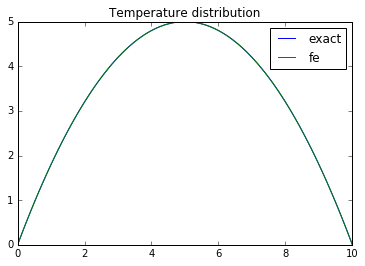

In [7]:
# Exact solution
x_1_exact = np.linspace(0, L, 100)
h_1_exact = h_1(x_1_exact)

# FE solution - solve using CG
h_1_fe = cg(K_1, b_1)[0]

plt.title('Temperature distribution')
plt.plot(x_1_exact, h_1_exact, label='exact')
plt.legend()

plt.plot(mesh, h_1_fe, label='fe')
plt.legend()

However, what if the number of observations are not equal to the number of parameters, and what if the observations are not made at the convenient point where the finite mesh of the data has been calcualted? Supposed there are $m$ observations on the problem - giving vector $\mathbf{h_{obs}}$ dimension $m \times 1$ - and $n$ parameters - giving vector $\mathbf{b_{h}}$ dimension $n \times 1$. Because of the dimension of $\mathbf{b_h}$, this makes the invert stiffness matrix $\mathbf{K^{-1}}$ dimension $n \times n$

$$
\mathbf{h_{obs}} = \mathbf{\Omega h_{fe}} = \mathbf{\Omega K^{-1} b_h}
$$

where $\mathbf{\Omega}$ represents the matrix mapping between our finite element solution $\mathbf{h_{fe}}$ to our observation data point of $\mathbf{h_{obs}}$. Please bear in mind that $\mathbf{\Omega}$ is multiplied in the left-hand side only to generate the 'fake' input data. In the real practical problem, we have already arrived at $\mathbf{h_{obs}}$ and hence such mapping is only needed on the right hand side in order to ensure equilibrium in matrix dimension between the two sides. 

$$
\mathbf{h_{obs}} = \mathbf{\Omega K^{-1} b_h}
$$

or for convenience, let $\mathbf{A = \Omega K^{-1}}$:

$$
\mathbf{h_{obs}} = \mathbf{A b_h}
$$

In [8]:
def gen_filt_mat(x, m):
    j = 0
    R = np.zeros((x.size, m.size))
    for i in range(x.size):
        for j in range(m.size):
            if m[j] > x[i]:
                break
        if (m[j] > x[i] and x[i] > m[j-1]):
            R[i, j-1] = (m[j] - x[i])/h
            R[i, j] = (x[i] - m[j-1])/h
        elif m[j] == x[i]:
            R[i, j] = 1.0
        elif m[j-1] == x[i]:
            R[i, j-1] = 1.0
    return R

In [9]:
# Get a matrix to only extract data at x = 1.5, 2.5 and 3.5
m_obs = 10 # number of obersations
n_pars = h_1_fe.size # Number of observation

# How about writing a function to define that, from x_obs
x_obs = np.linspace(mesh[0], mesh[-1], m_obs)
filt = gen_filt_mat(x_obs, mesh)

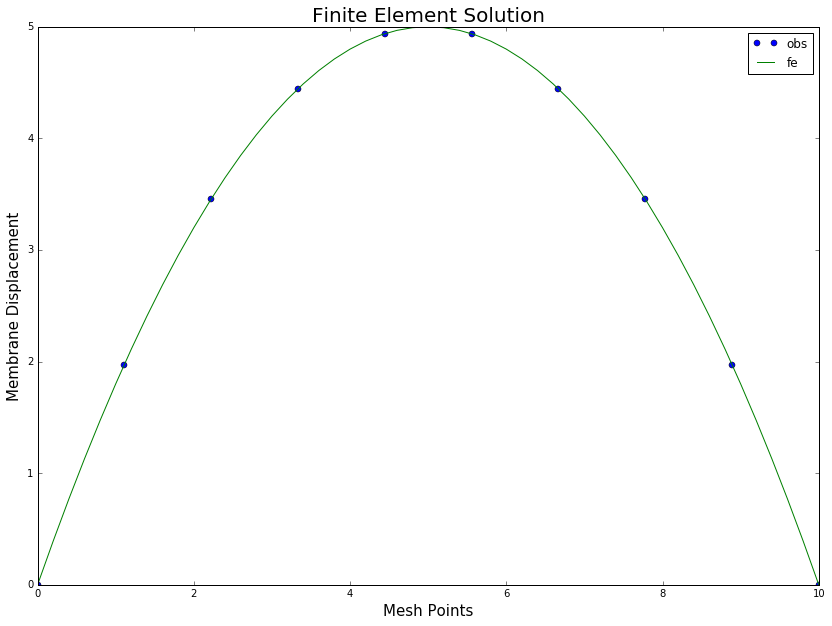

In [10]:
# Now let's plot these points

h_obs = filt.dot(h_1_fe) 

plt.figure(figsize=(14,10))
plt.title('Finite Element Solution', fontsize=20)
plt.plot(x_obs, h_obs, 'o', label='obs')
plt.plot(mesh, h_1_fe, label='fe')
plt.xlabel('Mesh Points', fontsize=15)
plt.ylabel('Membrane Displacement', fontsize=15)
plt.legend()

A = filt.dot(np.linalg.inv(K_1))

From Flath et al, finding the MAP point is equivalent to solving the least square solution of:

$$
D \sim   \left \{ \dfrac{1}{2}| \tilde{\mathbf{h}} -\mathbf{A}\mathbf{b_h}\|^2_{\mathbf{\Gamma}^{-1}_{noise}} + \dfrac{1}{2}| \mathbf{b_{h}} - \mathbf{\bar{b}}_{prior} \|^2_{\mathbf{\Gamma}^{-1}_{prior}} \right\} .
$$

which is equivalent to solving a regularized deterministic inverse problem, where $\mathbf{\Gamma}^{-1}_{prior} \in \mathbb{R}^{n \times n}$ plays the role of the regularisation operator, and $\mathbf{\Gamma}^{-1}_{noise} \in \mathbb{R}^{m \times m}$ is the weighting of the data misfit term. Moreover, the covariance matrix of the posterior pdf of model parameters, $\mathbf{\Gamma} \in \mathbb{R}^{n \times n}$, is given simply by the inverse of the Hessian matrix of the least squares
objective function, i.e.

$$
\mathbf{\Gamma}_{post} = \Big( \mathbf{A}^{T} \mathbf{\Gamma}^{-1}_{noise} \mathbf{A} + \mathbf{\Gamma}^{-1}_{prior} \Big)^{-1}
$$

Now differentiate with respect to $\mathbf{b_h}$ gives:

$$
\Big( \mathbf{A}^T \mathbf{\Gamma}^{-1}_{noise} \mathbf{A} + \mathbf{\Gamma}^{-1}_{prior} \Big) \mathbf{b_h} = \mathbf{A}^T \mathbf{\Gamma}^{-1}_{noise} \mathbf{\tilde{h}}_{obs} + \mathbf{\Gamma}^{-1}_{prior} \mathbf{\bar{b}_{prior}}
$$

which is essentially in the form of $\mathbf{Mb = k}$. 

Let's choose our prior mean with $\mathbf{\bar{b}}_{prior} = \mathbf{0}$ and our covariance matrices:

$$
\mathbf{\Gamma}_{prior} = \dfrac{h}{\beta_{prior}}\mathbf{I} \\
\mathbf{\Gamma}_{noise} = \dfrac{1}{\beta_{noise}}\mathbf{I}
$$

where $\beta_{prior}$ and $\beta_{noise}$ are the weighting factors and $h$ is the mesh size. 

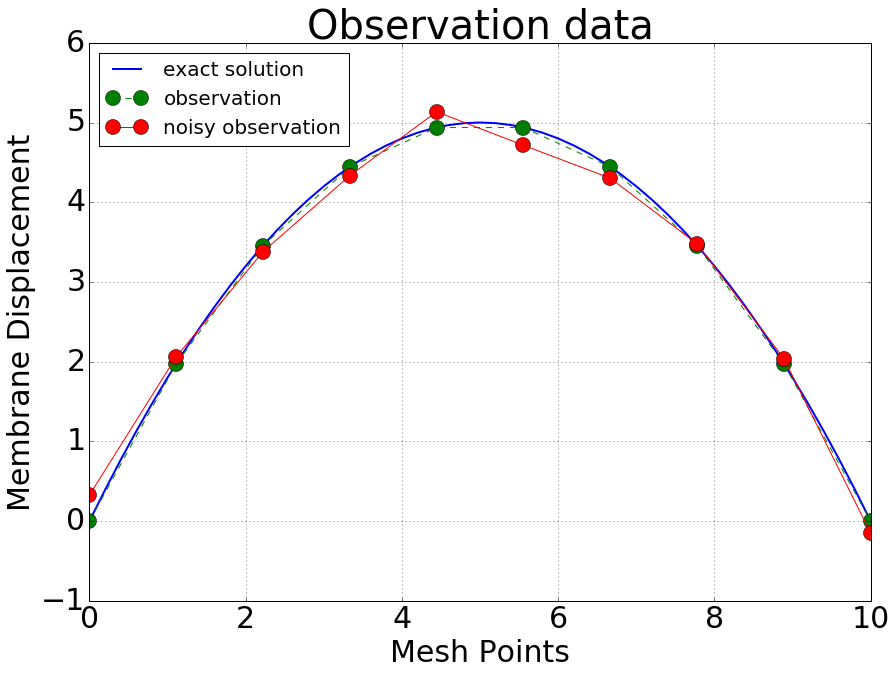

In [11]:
import matplotlib

# Define beta_prior and beta_noise
beta_prior = 5.0
beta_noise = 5.0

# Now generate those covariance matrices
Gamma_prior = (h)/(beta_prior)*np.identity(n_pars)
Gamma_noise = 1.0/(beta_noise)*np.identity(m_obs)

# Let's ignore the grad term for now (T.T)
# b_prior = b_1.copy()
b_prior = (-0.70)*np.ones(b_1.size)

# Generate fake data
noise = np.random.normal(0, (1.0/beta_noise), h_obs.size) 
h_obs_n = h_obs + (noise - np.mean(noise))

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 
plt.figure(figsize=(14,10))
plt.title('Observation data', fontsize=40)
plt.plot(mesh, h_1_fe, label='exact solution', linewidth=2.0)
plt.plot(x_obs, h_obs, '--o', label='observation', markersize=15)
plt.plot(x_obs, h_obs_n, '-o', label='noisy observation', markersize=15)
plt.xlabel('Mesh Points', fontsize=30)
plt.ylabel('Membrane Displacement', fontsize=30)
plt.legend(fontsize=20, loc=2)
plt.grid()

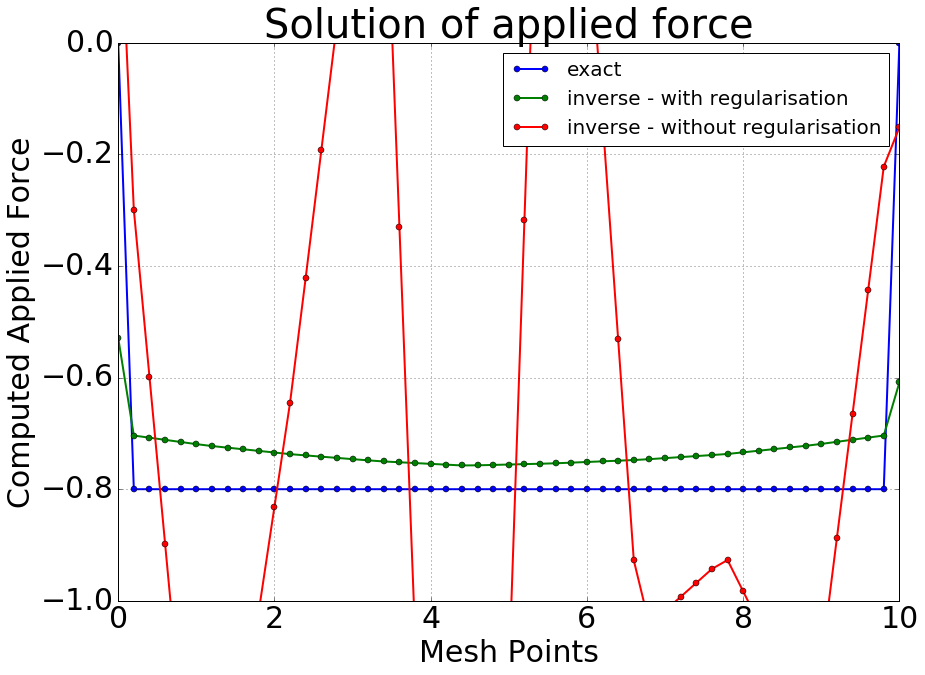

In [12]:
# Solve the normal stuff
M_1 = (A.T.dot(np.linalg.inv(Gamma_noise).dot(A))) + np.linalg.inv(Gamma_prior) 
c_1 = A.T.dot(np.linalg.inv(Gamma_noise).dot(h_obs_n)) + np.linalg.inv(Gamma_prior).dot(b_prior)

M_2 = (A.T.dot(np.linalg.inv(Gamma_noise).dot(A)))
c_2 = A.T.dot(np.linalg.inv(Gamma_noise).dot(h_obs_n))

# Now let's use CG to solve M_1 * b_hat = c_1
b_hat = cg(M_1, c_1)[0]
b_hat_noise = cg(M_2, c_2)[0]

# Let's plot and compare...
plt.figure(figsize=(14,10))
plt.title("Solution of applied force", fontsize=40)
plt.plot(mesh, b_1,'-o', label='exact', linewidth=2.0)
plt.plot(mesh, b_hat,'-o', label='inverse - with regularisation', linewidth=2.0)
plt.plot(mesh, b_hat_noise,'-o', label='inverse - without regularisation', linewidth=2.0)
plt.gca().set_ylim([-1.0,0.0])
plt.xlabel('Mesh Points', fontsize=30)
plt.ylabel('Computed Applied Force', fontsize=30)
plt.legend(fontsize=20)
plt.grid()

In [13]:
# Let's try and see the coveriance
Gamma_post = np.linalg.inv(M_1)
#print Gamma_post

Now let's check the Low-rank Approximation on the posterior covariance matrix as proposed by Flath et al. Let $\lambda_{i}$ and $\mathbf{v}_{i}$ be the eigenvalues and the eigenvectors of the *prior preconditioned data misfit* $ \mathbf{\bar{H}}_{misfit} \in \mathbb{R}^{n \times n} $ :  

$$
\mathbf{\bar{H}}_{misfit} = \mathbf{\Gamma}_{prior}^{1 / 2} \mathbf{A}^{T} \mathbf{\Gamma}^{-1}_{noise} \mathbf{A} \mathbf{\Gamma}_{prior}^{1 / 2}
$$

This gives the final approximation for the posterior matrix as:

$$
\mathbf{\Gamma}_{post} \approx \mathbf{\Gamma}_{prior}^{1 / 2} \Big( \mathbf{I} - \mathbf{V}_{r}\mathbf{D}_{r}\mathbf{V}^{T}_{r}\Big)\mathbf{\Gamma}_{prior}^{1 / 2}
$$

where $\mathbf{D}_{r} \in \mathbb{R}^{r \times r}$ is the diagonal matrix storing the eigenvalues of $\mathbf{\bar{H}}_{misfit}$ with $\mathbf{D}_{r} = diag(\lambda_{i} / (\lambda_{i} + 1))$; $\mathbf{V}_{r} \in \mathbb{R}^{n \times r}$ denotes the corresponding eigenvectors. 

(0.001, 100.0)

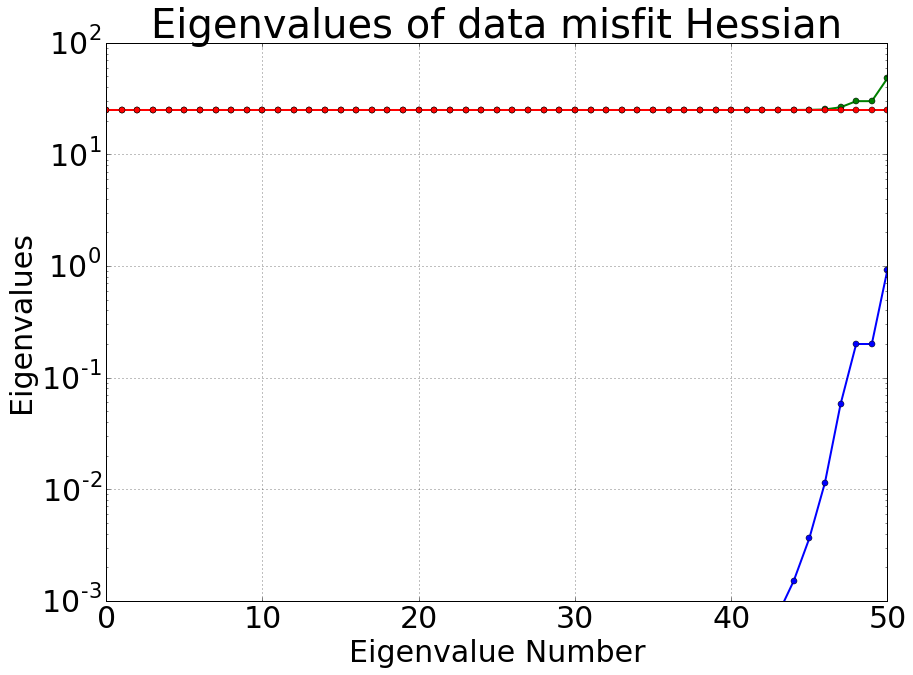

In [44]:
# Compute misfit matrix H_misfit
H_misfit = np.sqrt(Gamma_prior).dot(A.T.dot(np.linalg.inv(Gamma_noise).dot(A.dot(np.sqrt(Gamma_prior)))))

# And now let's find the eigenvalues and eigenvectors
EigVa, EigVe = np.linalg.eigh(H_misfit)
EigH2, EigVeH2 = np.linalg.eigh(M_1)
EigP, EigVP = np.linalg.eigh(Gamma_prior)

plt.figure(figsize=(14,10))
plt.title('Eigenvalues of data misfit Hessian', fontsize=40)
plt.xlabel('Eigenvalue Number', fontsize=30)
plt.ylabel('Eigenvalues', fontsize=30)
plt.semilogy(EigVa,'-o', linewidth=2.0)
plt.semilogy(EigH2,'-o', linewidth=2.0)
plt.semilogy(1/EigP,'-o', linewidth=2.0)
plt.grid()
plt.gca().set_ylim(ymin=1e-3)

In [15]:
# Now truncate some eigenvalues out
thres = 0.5 * EigVa[-1]

i = EigVa.size - 1

while (EigVa[i] > thres):
    i -= 1
    
Vr = EigVe[:, i:]
D = EigVa[i:]

# Now make Dr a square matrix 
Dr = np.diag(D/(D+1.0))

# And let's look at the approximation
Gamma_post_approx = np.sqrt(Gamma_prior).dot((np.identity(n_pars) - Vr.dot(Dr.dot(Vr.T))).dot(np.sqrt(Gamma_prior)))

print "All eigenvalues: \n", EigVa
print "Truncated eigenvalues: \n", D

# print "Posterior Covariance approx: \n", Gamma_post_approx
# print "Posterior Covariance exact: \n", Gamma_post

All eigenvalues: 
[ -1.93286579e-16  -1.23951184e-16  -1.21477411e-16  -1.08685307e-16
  -1.00626733e-16  -1.00429590e-16  -8.69008180e-17  -8.53578854e-17
  -7.54568209e-17  -6.71505212e-17  -5.11956508e-17  -3.09505536e-17
  -2.80589921e-17  -2.78344428e-17  -1.75221014e-17  -1.37298179e-17
  -6.97025706e-18  -6.54334331e-18  -3.94205115e-18  -3.12262061e-18
  -1.27273900e-18  -2.28330101e-21   6.39173002e-19   3.13546845e-18
   4.17712866e-18   8.87293505e-18   1.46618576e-17   2.01028586e-17
   2.13612017e-17   2.41467458e-17   3.33710257e-17   3.67847422e-17
   5.00531086e-17   5.41416344e-17   6.43563704e-17   8.30513611e-17
   9.83560418e-17   1.15406044e-16   1.20799426e-16   1.26993942e-16
   1.75276618e-16   3.20674023e-04   4.51693095e-04   7.61119452e-04
   1.50549881e-03   3.62589099e-03   1.14285073e-02   5.77634266e-02
   2.00000000e-01   2.00000000e-01   9.23910103e-01]
Truncated eigenvalues: 
[ 0.2        0.9239101]


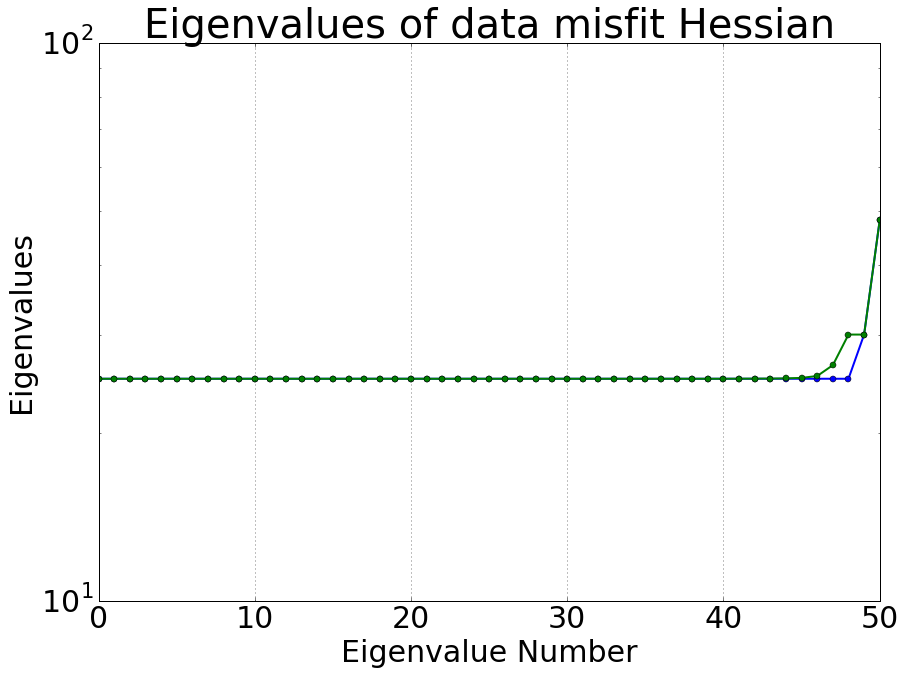

In [36]:
H1 = np.linalg.inv(Gamma_post_approx)
# And now let's find the eigenvalues and eigenvectors of Hessian
EigH1, EigVeH1 = np.linalg.eigh(H1)



plt.figure(figsize=(14,10))
plt.title('Eigenvalues of data misfit Hessian', fontsize=40)
plt.xlabel('Eigenvalue Number', fontsize=30)
plt.ylabel('Eigenvalues', fontsize=30)
plt.semilogy(EigH1,'-o', linewidth=2.0)
plt.semilogy(EigH2,'-o', linewidth=2.0)

plt.grid()

In [16]:
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

Comparison between Covariance Matrix


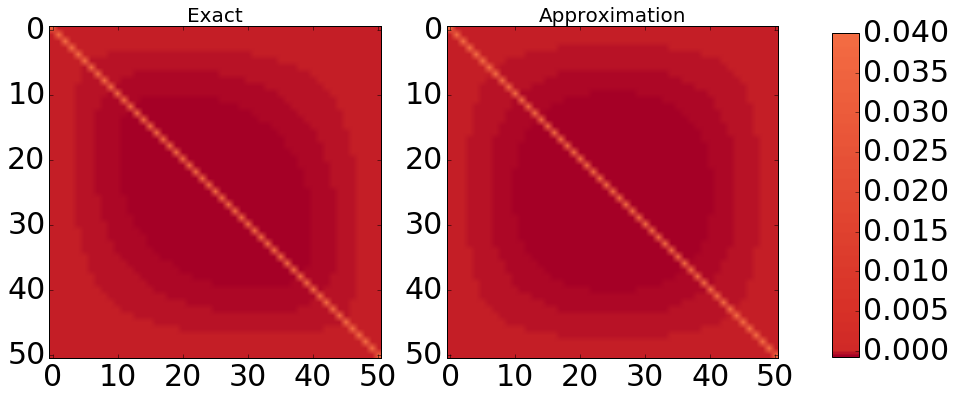

In [17]:
import matplotlib

print "Comparison between Covariance Matrix"

orig_cmap = matplotlib.cm.RdYlGn
shrunk_cmap = shiftedColorMap(orig_cmap, start=-0.025, midpoint=0.02, stop=0.20, name='shrunk')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
ax1.set_title('Exact', fontsize=20)
im = ax1.imshow(Gamma_post, cmap=shrunk_cmap)

ax2.set_title('Approximation', fontsize=20)
im = ax2.imshow(Gamma_post_approx, cmap=shrunk_cmap)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.36, 0.025, 0.3])
fig.colorbar(im, cax=cbar_ax)

In [18]:
print "L2 norm between the approx and the exact inverse Hessian: ", np.linalg.norm(Gamma_post_approx - Gamma_post, 2)

L2 norm between the approx and the exact inverse Hessian:  0.00666666666667


# REMARKS # 

1. As seen in the approach above, using the Low-rank Approximation of the Hessian Inverse, even if most of the eigenvalues/eigenvectors of the matrix $\mathbf{\bar{H}}_{misfit}$ are truncated (5 out of 6), the approximation of the posterior covariance matrix is still relatively close to the exact solution. 

2. The next step would be to try out the CG method proposed by Bryan in his thesis. Due to the (1) low-rank nature of the inverse Hessian matrix, and they are (2) symmetric and (3) positive definite, using CG is reasonable. 

3. The main goal of the proposed CG is to propose a matrix-free and scalable methods in order to solve Uncertainty Quantification for larger problems. 

[Uncertainty Quantification and Hessian Approximation using CG](UQHessianApproxCG.ipynb)

[Overview](Overview.ipynb) 